In [2]:
import os
import torch
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torchvision.io import read_image
from torchvision.transforms import Grayscale
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class HumanFacesDataset(Dataset):
  """Dataset class for storing and loading human face images"""

  def __init__(
      self,
      dataset_dir: str,
      train: bool = True
  ) -> None:
    """
    Args:
        dataset_dir (str): Path to the dataset directory.
        train (bool): Wether it is a train set.
    """
    self.dataset_dir = dataset_dir
    self.image_names = list(os.listdir(dataset_dir))
    self.train_set_size = int(len(self.image_names)*0.8)
    if train:
      self.image_names = self.image_names[:self.train_set_size]
      self.len = len(self.image_names)
    else:
      self.image_names = self.image_names[self.train_set_size:]
      self.len = len(self.image_names)

  def __len__(self) -> int:
    return self.len

  def __getitem__(self, idx: int) -> torch.Tensor:
    image_path = os.path.join(self.dataset_dir, self.image_names[idx])
    image = read_image(image_path)/255
    image = Grayscale()(image)
    return image

In [5]:
train_dataset = HumanFacesDataset("/content/drive/MyDrive/AI/datasets/ffhq")
test_dataset = HumanFacesDataset("/content/drive/MyDrive/AI/datasets/ffhq", train=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

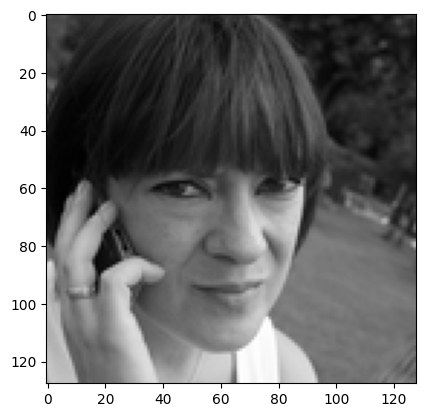

In [15]:
i = next(iter(train_loader))
i = (i[0][0]).squeeze()
plt.imshow(i, cmap='gray')

In [13]:
class HumanGanDiscriminator(nn.Module):
  """Discriminator part of GAN architecture"""

  def __init__(self) -> None:
    super(HumanGanDiscriminator, self).__init__()
    self.flatten = nn.Flatten()
    self.model = nn.Sequential(
        nn.Linear(16384, 752),
        nn.ReLU(),
        nn.Linear(752, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    output = self.model(x)
    return output

In [16]:
class HumanGanGenerator(nn.Module):
  """Generator part of GAN architecture"""

  def __init__(self) -> None:
    super(HumanGanGenerator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 752),
        nn.ReLU(),
        nn.Linear(752, 16384),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    output = self.model(x)
    output = output.view(-1, 1, 128, 128)
    return output

In [17]:
learning_rate = 1e-3
epochs = 100
batch_size = 64

G = HumanGanGenerator().to(device)
D = HumanGanDiscriminator().to(device)

loss_fn = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=learning_rate)
d_opt = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [19]:
for epoch in range(epochs):
  for batch, real_images in enumerate(train_loader):
    real_images = real_images.to(device)
    noise = torch.randn(real_images.shape[0], 128).to(device)
    fake_images = G(noise)
    real_labels = torch.ones(real_images.shape[0], 1).to(device)
    fake_labels = torch.zeros(fake_images.shape[0], 1).to(device)
    real_output = D(real_images)
    fake_output = D(fake_images)
    outputs = torch.cat((real_output, fake_output), 0)
    targets = torch.cat((real_labels, fake_labels), 0)

    d_loss = loss_fn(outputs, targets)
    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    noise = torch.randn(real_images.shape[0], 128).to(device)
    fake_images = G(noise)
    fake_labels = torch.ones(real_images.shape[0], 1).to(device)
    fake_output = D(fake_images)
    g_loss = loss_fn(fake_output, fake_labels)
    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

with torch.no_grad():
      noise = torch.randn(real_images.shape[0], 128).to(device)
      fake = G(noise)
      fake = np.array(fake[0].cpu())
      fake = (fake.T).squeeze()
      plt.imshow((fake*255).astype(np.uint8), cmap='gray')
      print("Final Generator Loss", g_loss.item())

print("Done!")

Epoch: 0, d_loss: 2.7190146446228027, g_loss: 0.07884106785058975
Epoch: 10, d_loss: 0.39015889167785645, g_loss: 3.6911046504974365
Epoch: 20, d_loss: 0.3795764148235321, g_loss: 4.401756286621094
Epoch: 30, d_loss: 0.4117719531059265, g_loss: 6.3872199058532715
Epoch: 40, d_loss: 1.0564019680023193, g_loss: 0.8243123292922974
Epoch: 50, d_loss: 0.2721121609210968, g_loss: 6.658864974975586
Epoch: 60, d_loss: 0.04299650341272354, g_loss: 6.865235328674316
Epoch: 70, d_loss: 0.6882920265197754, g_loss: 0.547419548034668
Epoch: 80, d_loss: 2.6897215843200684, g_loss: 0.5786513090133667
Epoch: 90, d_loss: 0.300296813249588, g_loss: 1.7660810947418213
Final Generator Loss 0.24680733680725098
Done!
